In [ ]:
!pip install -q scikit-learn pycaret xgboost imblearn plotly
!pip install optuna

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as pt
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")

import optuna
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, make_scorer
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.over_sampling import SMOTE

In [ ]:
# Read in training data
drive_url = "https://drive.google.com/file/d/1J70Sz3_t7znOFZaDHe3SEtpJ69qCUyZy/view?usp=sharing"

# Convert the Google Drive URL to a direct download URL
file_id = drive_url.split('/d/')[1].split('/')[0]
download_url = f"https://drive.google.com/uc?id={file_id}"

# Read the CSV file into a DataFrame
df = pd.read_csv(download_url)

# Display the first few rows of the DataFrame
print(df.head())


# Read in test data
drive_url = "https://drive.google.com/file/d/1X7Ezau9dfp1BKYyolYEVZzGQqobtEpGn/view?usp=sharing"
# Convert the Google Drive URL to a direct download URL
file_id = drive_url.split('/d/')[1].split('/')[0]
download_url = f"https://drive.google.com/uc?id={file_id}"

# Read the CSV file into a DataFrame
df_test = pd.read_csv(download_url)

# Display the first few rows of the DataFrame
print(df_test.head())


   person_age person_gender person_education  person_income  person_emp_exp  \
0        24.0          male           Master        58914.0               2   
1        23.0        female      High School        45873.0               2   
2        29.0        female           Master       240947.0               7   
3        30.0        female         Bachelor        96316.0              10   
4        29.0          male         Bachelor        73033.0               7   

  person_home_ownership  loan_amnt loan_intent  loan_int_rate  \
0                   OWN     4400.0     VENTURE           5.99   
1                  RENT    11000.0     VENTURE          11.01   
2              MORTGAGE    10000.0     VENTURE          12.69   
3              MORTGAGE     6000.0     MEDICAL          13.49   
4              MORTGAGE     8000.0    PERSONAL          10.51   

   loan_percent_income  cb_person_cred_hist_length  credit_score  \
0                 0.07                         4.0           656  

In [ ]:
df.isnull().sum()

,0
person_age,0
person_gender,0
person_education,0
person_income,0
person_emp_exp,0
person_home_ownership,0
loan_amnt,0
loan_intent,0
loan_int_rate,0
loan_percent_income,0


In [33]:
# rule features
num_fea = [
    "person_age", "person_income", "person_emp_exp",
    "loan_amnt", "loan_int_rate", "loan_percent_income",
    "cb_person_cred_hist_length", "credit_score"
]

cate_fea = [
    "person_gender", "person_education",
    "person_home_ownership", "loan_intent",
    "previous_loan_defaults_on_file"
]

trgt_col = "loan_status"
id_col = "Loan_ID"

# preprocess data
num_trans = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('poly', PolynomialFeatures(degree=2, interaction_only=True)),  # Add feature interactions
    ('scaler', StandardScaler())
])

cate_trans = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_trans, num_fea),
        ('cat', cate_trans, cate_fea)
    ],
    remainder='drop'
)

# feature engineering
def enhance_features(df):
    df = df.copy()

    if 'person_emp_exp' in df.columns and 'person_age' in df.columns:
        df['employment_stability'] = df['person_emp_exp'] / (df['person_age'] - 18 + 1e-6)

    if 'loan_amnt' in df.columns and 'credit_score' in df.columns:
        df['credit_utilization'] = df['loan_amnt'] / (df['credit_score'] + 1e-6)

    if 'loan_percent_income' in df.columns and 'person_income' in df.columns:
        df['debt_to_income'] = df['loan_percent_income'] * np.log1p(df['person_income'])

    # New Feature: Income to Debt Ratio
    if 'person_income' in df.columns and 'loan_amnt' in df.columns:
        df['income_to_debt_ratio'] = df['person_income'] / (df['loan_amnt'] + 1e-6)

    return df


In [41]:
# hyperparameterization
def objective(trial, X_train, y_train):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000, step=250),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, step=0.01),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0, step=0.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.1),
        'gamma': trial.suggest_float('gamma', 0.0, 0.5, step=0.05),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0, step=0.1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0, step=0.1),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 5.0, step=0.5)
    }

    model = XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=42,
        use_label_encoder=False,
        **params
    )

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scorer = make_scorer(f1_score)

    score = cross_val_score(model, X_train, y_train, cv=cv, scoring=f1_scorer).mean()
    return score

In [ ]:
### Now we bd the model

In [ ]:
# create a ID prepare to the csv file
test_id = pd.Series(range(1, len(df_test) + 1))

# Perform simple feature enhancement
train_df = enhance_features(df)
test_df = enhance_features(df_test)

# datasets split
X_train = train_df.drop(columns=[trgt_col])
y_train = train_df[trgt_col].astype(int)
X_test = test_df.copy()

# datasets preprocess
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

# Balancing with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_prep, y_train)

### Hyperparameter using Optuna

# Setting the maximum number of attempts
MAX_TRIALS = 13

# Record the number of tests
trial_counter = 0

# Define Early Stopping Logic
def objective_with_early_stop(trial):
    global trial_counter
    trial_counter += 1

    # Run the original objective function
    score = objective(trial, X_train_resampled, y_train_resampled)

    # If the set number of trials is reached, it stops.
    if trial_counter >= MAX_TRIALS:
        raise optuna.exceptions.TrialPruned()

    return score

# Run Optuna and limit the maximum number of trials
study = optuna.create_study(direction='maximize')
study.optimize(objective_with_early_stop, n_trials=MAX_TRIALS, catch=(optuna.exceptions.TrialPruned,))

# Output the current optimal hyperparameters
print("Best hyperparameters after {} trials:".format(MAX_TRIALS), study.best_params)

[I 2025-02-20 23:03:19,465] A new study created in memory with name: no-name-3085871d-1ed8-464b-b494-9d0f6c46a728
[I 2025-02-20 23:05:41,949] Trial 0 finished with value: 0.9551318535321401 and parameters: {'n_estimators': 1500, 'learning_rate': 0.06999999999999999, 'max_depth': 6, 'subsample': 0.7, 'colsample_bytree': 0.7, 'gamma': 0.45, 'reg_alpha': 0.4, 'reg_lambda': 0.1, 'scale_pos_weight': 2.5}. Best is trial 0 with value: 0.9551318535321401.
[I 2025-02-20 23:07:10,827] Trial 1 finished with value: 0.9514537491746362 and parameters: {'n_estimators': 500, 'learning_rate': 0.08, 'max_depth': 8, 'subsample': 0.9, 'colsample_bytree': 0.7, 'gamma': 0.30000000000000004, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'scale_pos_weight': 5.0}. Best is trial 0 with value: 0.9551318535321401.
[I 2025-02-20 23:09:26,656] Trial 2 finished with value: 0.9509460964161534 and parameters: {'n_estimators': 1000, 'learning_rate': 0.05, 'max_depth': 7, 'subsample': 0.5, 'colsample_bytree': 0.7, 'gamma': 0.45,

Best hyperparameters after 13 trials: {'n_estimators': 500, 'learning_rate': 0.05, 'max_depth': 10, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.15000000000000002, 'reg_alpha': 0.0, 'reg_lambda': 0.30000000000000004, 'scale_pos_weight': 1.0}


In [34]:
# Train with best parameters
model_final = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    use_label_encoder=False,
    **study.best_params
    )
model_final.fit(X_train_resampled, y_train_resampled)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.15000000000000002, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

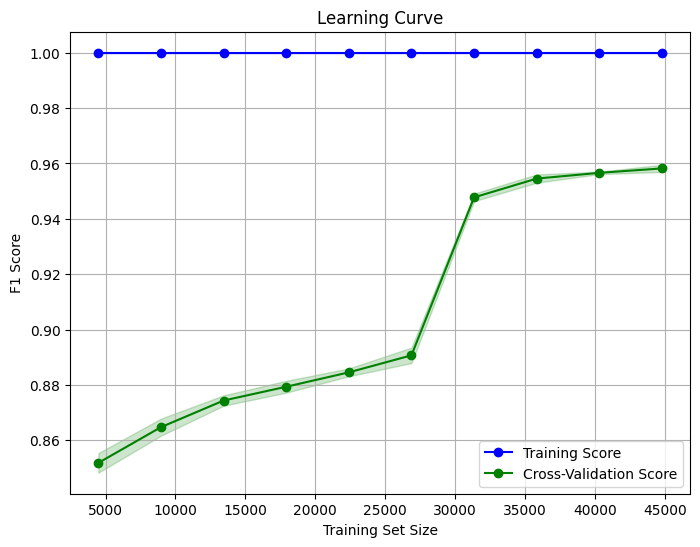

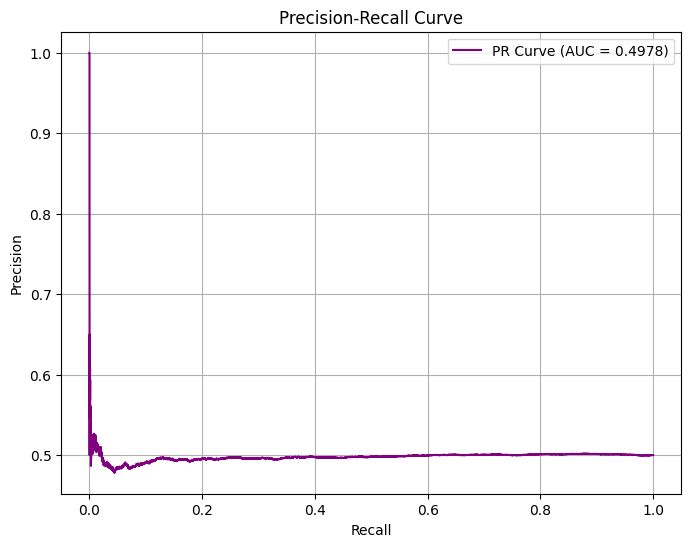

In [42]:
from sklearn.model_selection import learning_curve
from sklearn.metrics import precision_recall_curve, auc
from sklearn.model_selection import cross_val_predict

# Generate Learning Curve data
train_sizes, train_scores, test_scores = learning_curve(
    model_final, X_train_resampled, y_train_resampled, cv=cv, scoring='f1', train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)


# Compute mean and standard deviation of training and validation scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot Learning Curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label='Training Score', marker='o', color='blue')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.plot(train_sizes, test_mean, label='Cross-Validation Score', marker='o', color='green')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='green', alpha=0.2)
plt.xlabel('Training Set Size')
plt.ylabel('F1 Score')
plt.title('Learning Curve')
plt.legend()
plt.grid()
plt.show()

# Generate Precision-Recall Curve
y_prob = np.random.rand(len(y_train_resampled))  # Simulated probabilities
precision, recall, _ = precision_recall_curve(y_train_resampled, y_prob)
pr_auc = auc(recall, precision)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.4f})', color='purple')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Assuming final_model is your trained model and X_test is your test dataset
# Generate predictions
X_test = preprocessor.transform(test_df)
predictions = model_final.predict(X_test)

# Create a DataFrame with ID and TARGET columns
submission_df = pd.DataFrame({
    'ID': range(1, len(df_test) + 1),
    'TARGET': predictions
})

# Save to submit.csv
submission_df.to_csv('submit.csv', index=False)

print("submit.csv file created successfully!")

# # Download the CSV file to local machine
# files.download('submit.csv')

submit.csv file created successfully!
